# SHE (Simplified Hopfield Energy) method 

This method first computes the mean of the internal layer representation of ID data
for each ID class. This mean is seen as the average of the ID activation patterns
as defined in the original paper.
The method then returns the maximum value of the dot product between the internal
layer representation of the input and the average patterns, which is a simplified
version of Hopfield energy as defined in the original paper.

**Reference**
[Out-of-Distribution Detection based on In-Distribution Data Patterns Memorization
with Modern Hopfield Energy](https://openreview.net/forum?id=KkazG4lgKL), ICLR 2023


### Imports


In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from oodeel.methods import SHE
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import OODDataset
from oodeel.utils.tf_training_tools import train_tf_model

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## First experiment: MNIST[0-4] vs MNIST[5-9]

For this first experiment, we train a toy convolutional network on the MNIST dataset
restricted to digits 0 to 4. After fitting the train subset of this dataset to the gram
method, we will compare the scores returned for MNIST[0-4] (in-distribution) and
MNIST[5-9] (out-of-distribution) test subsets.


### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote core classes such as `OODDataset` and `OODBaseDetector`.


In [3]:
# === Load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- Load train/test MNIST dataset
ds_train = OODDataset("mnist", load_kwargs=dict(split="train"))
data_test = OODDataset("mnist", load_kwargs=dict(split="test"))

# 2- Split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
ds_train, _ = ds_train.split_by_class(in_labels)
oods_in, oods_out = data_test.split_by_class(in_labels)


# 3- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


ds_train = ds_train.prepare(batch_size, preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size, preprocess_fn, with_ood_labels=False)
ds_out = oods_out.prepare(batch_size, preprocess_fn, with_ood_labels=False)

clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] on a simple MLP using `train_tf_model` function.


In [4]:
# === Train / Load model ===
model_path_mnist_04 = os.path.join(model_path, "mnist_mlp_0-4.h5")

try:
    # if the model exists, load it
    model = tf.keras.models.load_model(model_path_mnist_04)
except OSError:
    # else, train a new model
    train_config = {
        "model": "toy_mlp",
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,
    }

    model = train_tf_model(ds_train, **train_config)

41/41 [==============================] - 1s 12ms/step - loss: 0.0217 - accuracy: 0.9934
Test accuracy:	0.9934

=== Penultimate features viz ===


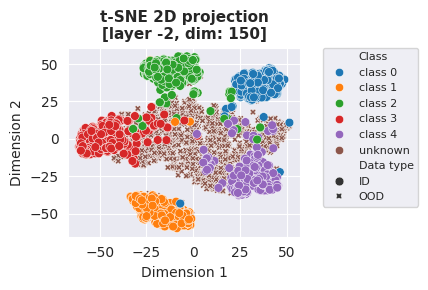

In [5]:
_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### SHE score

We now fit a SHE detector with MNIST[0-4] train dataset, and compare OOD scores
returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


In [6]:
# === gram scores ===
she = SHE()
she.fit(model, ds_train, feature_layers_id=["dense", "dense_1"])

In [7]:
scores_in, _ = she.score(ds_in)
scores_out, _ = she.score(ds_out)

# Since many scores are equal to 0, we add a random noise to avoid bugs
# in Auroc and TPR computation.
scores_in += np.random.random_sample(size=scores_in.shape) * 10e-6
scores_out += np.random.random_sample(size=scores_out.shape) * 10e-6

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

=== Metrics ===
auroc      0.725072
fpr95tpr   0.689239



=== Plots ===


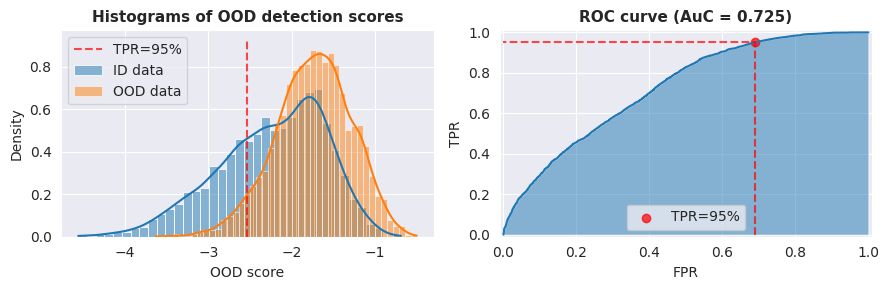

In [8]:
print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

## Second experiment: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN**
(out-of-distribution dataset).


### Data loading

- In-distribution data: CIFAR-10
- Out-of-distribution data: SVHN


In [9]:
# === Load ID and OOD data ===
batch_size = 128

# 1a- Load in-distribution dataset: CIFAR-10
ds_fit = OODDataset("cifar10", load_kwargs={"split": "train"}, input_key="image")
ds_in = OODDataset("cifar10", load_kwargs={"split": "test"}, input_key="image")

# 1b- Load out-of-distribution dataset: SVHN
ds_out = OODDataset("svhn_cropped", load_kwargs={"split": "test"})


# 2- prepare data (preprocess, shuffle, batch)
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


ds_fit = ds_fit.prepare(batch_size, preprocess_fn)
ds_in = ds_in.prepare(batch_size, preprocess_fn)
ds_out = ds_out.prepare(batch_size, preprocess_fn)
clear_output()

### Model loading

The model is a **ResNet** pretrained on CIFAR-10 and getting an accuracy score of
92.75%.


In [10]:
# === Load model ===
# ResNet pretrained on CIFAR-10
model_path_resnet_cifar10 = tf.keras.utils.get_file(
    "cifar10_resnet256.h5",
    origin="https://share.deel.ai/s/kram9kLpx6JwRX4/download/cifar10_resnet256.h5",
    cache_dir=model_path,
    cache_subdir="",
)
model = tf.keras.models.load_model(model_path_resnet_cifar10)

79/79 [==============================] - 3s 13ms/step - loss: 0.1268 - accuracy: 0.9278
Test accuracy:	0.9278

=== Penultimate features viz ===


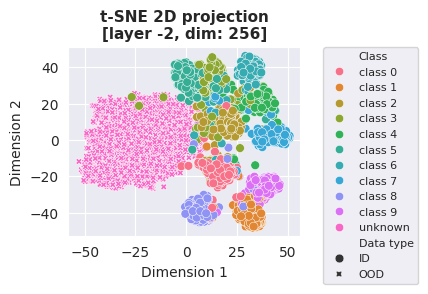

In [11]:
# Evaluate model
model.compile(metrics=["accuracy"])
_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### SHE score

We now fit a SHE detector with CIFAR-10 train dataset, and compare OOD scores returned
for CIFAR-10 (ID) and SVHN (OOD) test datasets.


In [12]:
# === gram scores ===
she = SHE()
she.fit(
    model, 
    ds_fit, 
    feature_layers_id=['conv2d_18', 'activation_17', 'conv2d_37', 'activation_35', 'conv2d_56', 'activation_53', 'flatten']
)

scores_in, _ = she.score(ds_in)
scores_out, _ = she.score(ds_out)

scores_in += np.random.random_sample(size=scores_in.shape) * 10e-6
scores_out += np.random.random_sample(size=scores_out.shape) * 10e-6

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")


=== Metrics ===
auroc      0.988443
fpr95tpr   0.054600



=== Plots ===


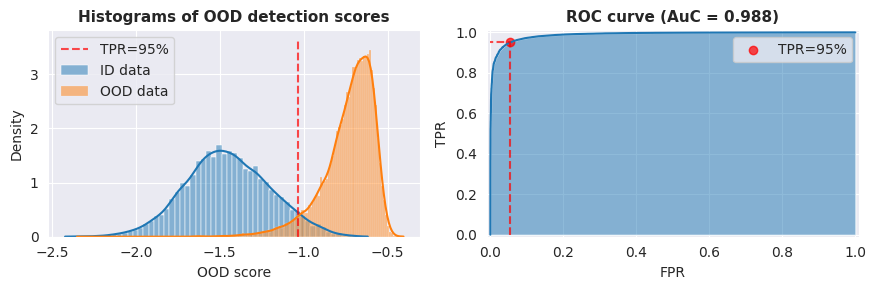

In [13]:
print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()